In [1]:
import netCDF4 as nc4
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd
import time
# import xarray as xr

### Read in climate and extract the corresponding time series

In [2]:
# Data path
# GSWP3
f_sanrafael = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/sanrafael.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/sanrafael.test.1958_2013.nc'
f_villamadero = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/villamadero.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/villamadero.test.1958_2013.nc'
# TerraClimate
# Wind speed is at 10m.
f_terra_tmax_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmax_'
f_terra_tmin_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmin_'
f_terra_prec_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ppt_'
f_terra_wind_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ws_'
f_terra_rad_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_srad_'
suf = '.nc'

# ERA (1979 - 2022)
f_era_tbot_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tbot/elmforc.ERA5.c2018.0.25d.t2m.'
f_era_prec_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mcpr.'
f_era_prel_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mlspr.'
f_era_wind_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/wind/elmforc.ERA5.c2018.0.25d.v10.'
f_era_rad_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/swdn/elmforc.ERA5.c2018.0.25d.msdwswrf.'
f_era_pbot_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/pbot/elmforc.ERA5.c2018.0.25d.sp.'
f_era_lwdn_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/lwdn/elmforc.ERA5.c2018.0.25d.msdwlwrf.'
f_era_dewt_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tdew/elmforc.ERA5.c2018.0.25d.d2m.'

# Sr - 19.26932, -98.61660 
# Vm - 19.35500, -101.27070
# Rio Frio - 19.34, -98.66
latid_sr = int((90.0-19.0)*24.0) - round(0.26932/(1.0/24.0))
lonid_sr = int((180.0-98.0)*24.0) - round(0.6166/(1.0/24.0))
latid_vm = int((90.0-19.0)*24.0) - round(0.355/(1.0/24.0))
lonid_vm = int((180.0-101.0)*24.0) - round(0.2707/(1.0/24.0))

# For ERA
latid_sr_era = int((90.0+19.0)*4.0) + round(0.26932/(1.0/4.0))
lonid_sr_era = int((360.0-98.0)*4.0) - round(0.6166/(1.0/4.0))
latid_vm_era = int((90.0+19.0)*4.0) + round(0.355/(1.0/4.0))
lonid_vm_era = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For GPCC-2020
latid_sr_gpcc = int((90.0-19.0)*4.0) - round(0.34/(1.0/4.0))
lonid_sr_gpcc = int((360.0-98.0)*4.0) - round(0.66/(1.0/4.0))
latid_vm_gpcc = int((90.0-19.0)*4.0) - round(0.355/(1.0/4.0))
lonid_vm_gpcc = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For Chirps-v2
latid_sr_chirps = int((50.0+19.0)*20.0) + round(0.26932/(1.0/20.0))
lonid_sr_chirps = int((180.0-98.0)*20.0) - round(0.6166/(1.0/20.0))
latid_vm_chirps = int((50.0+19.0)*20.0) + round(0.355/(1.0/20.0))
lonid_vm_chirps = int((180.0-101.0)*20.0) - round(0.2707/(1.0/20.0))

In [3]:
# Parameters for calculating vapor pressure
a1=6.107799961
a2=4.436518521e-1
a3=1.428945805e-2
a4=2.650648471e-4
a5=3.031240396e-6
a6=2.034080948e-8
a7=6.136820929e-11


In [4]:
# Extract site-level ERA data
# This step will take much longer than expected. Usually 1 hour every 10 years
start = time.time()

fout_pre = '/pscratch/sd/s/sshu3/site_met/sanrafael_era5/'
fout_suf = '.nc'

yrbeg = 1979
yrend = 2023

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        dom = np.array((31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))
        nlen = 24 * dom[j-1]
        
        sr_tbot_era = np.zeros((nlen))
        sr_prec_era = np.zeros((nlen))
        sr_wind_era = np.zeros((nlen))
        sr_rad_era = np.zeros((nlen))
        sr_tdew_era = np.zeros((nlen))
        sr_pbot_era = np.zeros((nlen))
        sr_qa_era = np.zeros((nlen))
        sr_rh_era = np.zeros((nlen))
        sr_lrad_era = np.zeros((nlen))
        
        # TBOT
        if(j < 10):
            fp = f_era_tbot_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_tbot_pre+str(i)+'-'+str(j)+suf
        dtc = nc4.Dataset(fp)
        dtbot = dtc['t2m']
        temp_array_1 = dtbot[:,latid_sr_era,lonid_sr_era]
        dtc.close()       
        sr_tbot_era = copy.deepcopy(temp_array_1)

        # Monthly Precipitation mm/s
        if(j < 10):
            fp = f_era_prec_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_prec_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dprec = dtc['mcpr']
        temp_array_1 = dprec[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        if(j < 10):
            fp = f_era_prel_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_prel_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dprel = dtc['mlspr']
        temp_array_2 = dprel[:,latid_sr_era,lonid_sr_era]
        dtc.close()               
        sr_prec_era = copy.deepcopy(temp_array_1+temp_array_2)
        
        # Wind, 10 m wind speed, m s-1
        if(j < 10):
            fp = f_era_wind_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_wind_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dwind_u = dtc['u10']
        dwind_v = dtc['v10']
        temp_array_1u = dwind_u[:,latid_sr_era,lonid_sr_era]
        temp_array_1v = dwind_v[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_wind_era = copy.deepcopy(np.sqrt(temp_array_1u*temp_array_1u+temp_array_1v*temp_array_1v))
        
        # Radiation, W m-2
        if(j < 10):
            fp = f_era_rad_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_rad_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        drad = dtc['msdwswrf']
        temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_rad_era = copy.deepcopy(temp_array_1)
        
        # Longwave radiation, W m-2
        if(j < 10):
            fp = f_era_lwdn_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_lwdn_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        drad = dtc['msdwlwrf']
        temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_lrad_era = copy.deepcopy(temp_array_1)
        
        # Dew point T, K
        if(j < 10):
            fp = f_era_dewt_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_dewt_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        d2m = dtc['d2m']
        temp_array_1 = d2m[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_tdew_era = copy.deepcopy(temp_array_1)
        
        # Surface pressure, Pa
        if(j < 10):
            fp = f_era_pbot_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_pbot_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dsp = dtc['sp']
        temp_array_1 = dsp[:,latid_sr_era,lonid_sr_era]
        dtc.close()
        sr_pbot_era = copy.deepcopy(temp_array_1)
        
        # # Transfer dew point temperature to specific humidity
        # dew = sr_tdew_era - 273.16
        # ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        # ea = ea * 100.0 # Conversion millibar --> Pascal
        # # 0.62198 - humidity ratio
        # sr_qa_era = 0.62198*ea/(sr_pbot_era - 0.377*ea)
        
        # Transfer dew point temperature to relative humidity
        dew = sr_tdew_era - 273.16
        tair = sr_tbot_era - 273.16
        ea = a1 +dew*(a2+dew*(a3+dew*(a4+dew*(a5+dew*(a6+dew*a7)))))
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        sr_rh_era = ea/(es+1e-10)
      
        # Write into corresponding file
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        dtc['TBOT'][:] = sr_tbot_era
        dtc['PSRF'][:] = sr_pbot_era
        dtc['PRECTmms'][:] = sr_prec_era
        dtc['WIND'][:] = sr_wind_era
        dtc['FSDS'][:] = sr_rad_era
        dtc['TDEW'][:] = sr_lrad_era
        dtc['QBOT'][:] = sr_rh_era
        dtc.close()

end = time.time()
print('Time elapsed: ', end - start)
        

Time elapsed:  6505.569532394409


### Bias correction for site level atmospheric forcing

In [5]:
# Obtain TerraClimate data for site level
yrbeg = 1979
yrend = 2023
nlen = 12 * (yrend - yrbeg + 1)
sr_tmax_terra = np.zeros((nlen))
sr_tmin_terra = np.zeros((nlen))
sr_prec_terra = np.zeros((nlen))
sr_wind_terra = np.zeros((nlen))
sr_rad_terra = np.zeros((nlen))
vm_tmax_terra = np.zeros((nlen))
vm_tmin_terra = np.zeros((nlen))
vm_prec_terra = np.zeros((nlen))
vm_wind_terra = np.zeros((nlen))
vm_rad_terra = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    pbeg = (i-yrbeg)*12
    pend = (i-yrbeg+1)*12
    # Tmax
    fp = f_terra_tmax_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmax = dtc['tmax']
    sr_tmax_terra[pbeg:pend] = dtmax[:,latid_sr,lonid_sr]
    dtc.close()
    # Tmin
    fp = f_terra_tmin_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmin = dtc['tmin']
    sr_tmin_terra[pbeg:pend] = dtmin[:,latid_sr,lonid_sr]
    dtc.close()
    # Wind, 10 m wind speed, m s-1
    fp = f_terra_wind_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dwind = dtc['ws']
    sr_wind_terra[pbeg:pend] = dwind[:,latid_sr,lonid_sr]
    dtc.close()


In [6]:
# Get Daymet vapor pressure data for site level
# Daymet starts from 1980, so we don;t perform any adjustment for year 1979.
# We only use the actual vapor pressure
# Then this daily timeseries will be user to correct relative humidity of San Rafael site through linear scale
fp = '/pscratch/sd/s/sshu3/site_met/daymet/Sanrafael_daymet.csv'
df_daymet = pd.read_csv(fp, header=0)
yrbeg = 1980
yrend = 2022
nlen = 365 * (yrend - yrbeg + 1)
sr_ea_daymet = df_daymet.vp.to_numpy()[(yrbeg-1980)*365:(yrend - yrbeg +1)*365]



In [29]:
# reopen the climate data if needed
yrbeg = 1979
yrend = 2023
fout_pre = '/pscratch/sd/s/sshu3/site_met/sanrafael_era5_bias_corrected/'
fout_suf = '.nc'

jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
jday_cnt = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_era = dtc['TBOT'][:]
        sr_wind_era = dtc['WIND'][:]
        sr_rh_era = dtc['QBOT'][:]
        # sr_pbot_era = dtc['PSRF'][:]

        # For each month we get the maximum and minimum temperature and calculate the mean of that month.
        # Use the difference between TerraClimate and ERA5 to correct the temperature
        # Same method is applied to correct wind speed.
        # Before correcting temperature bias, dew point temperature must be transferred into either specific or relative humidity.
        # Currently we just use linear scaling (Chen et al., 2022)
        sr_tmax_era = np.nanmean(np.nanmax(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_tmin_era = np.nanmean(np.nanmin(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_wmean_era = np.nanmean(sr_wind_era)
        idx = (i-yrbeg)*12+j-1
        corr_tbot = (sr_tmax_terra[idx]+273.16 - sr_tmax_era + sr_tmin_terra[idx]+273.16 - sr_tmin_era) / 2.0
        sr_tbot_era[:] = sr_tbot_era[:] + corr_tbot
        corr_wind =  sr_wind_terra[idx] - sr_wmean_era
        sr_wind_era[:] = sr_wind_era[:] + corr_wind
        
        # Use daymet actual vapor pressure to adjust RH
        nlen = 24 * jday_cnt[j-1]       
        ea_copy = np.zeros((nlen))
        
        tair = sr_tbot_era - 273.16
        es = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        ea = es * sr_rh_era
        ea_daily = np.nanmean(ea.reshape(-1, 24), axis=1)
        if(i>=1980):
            jday_beg_pt = 365*(i-1980)+jday_beg[j-1]
            jday_end_pt = 365*(i-1980)+jday_end[j-1]
            corr_ea = sr_ea_daymet[jday_beg_pt:jday_end_pt]*0.01 - ea_daily
            for p in np.arange(0, jday_cnt[j-1]):
                ea[24*p:24*(p+1),0,0] = ea[24*p:24*(p+1),0,0] + corr_ea[p]
                sr_rh_era[24*p:24*(p+1),0,0] = ea[24*p:24*(p+1),0,0]/es[24*p:24*(p+1),0,0]

        # Sanity check for RH
        sr_rh_era[sr_rh_era>1.0] = 1.0
        sr_rh_era[sr_rh_era<0.1] = 0.1
        # # Transfer RH to Q
        # ea = sr_rh_era*es    # Update ea
        # ea = ea * 100.0 # Conversion millibar --> Pascal
        # # # 0.62198 - humidity ratio
        # sr_qa_era = 0.62198*ea/(sr_pbot_era - 0.377*ea)       
        
        dtc['TBOT'][:] = sr_tbot_era
        dtc['WIND'][:] = sr_wind_era
        dtc['QBOT'][:] = sr_rh_era * 100
        dtc.close()



In [30]:
# Read in data and make plot to validate
# Obtain TerraClimate data
yrbeg = 1979
yrend = 2023
nlen = 12 * (yrend - yrbeg)
sr_tmax_era = np.zeros((nlen))
sr_tmin_era = np.zeros((nlen))
sr_wmean_era = np.zeros((nlen))
sr_ea_era = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = fout_pre+str(i)+'-0'+str(j)+fout_suf
        else:
            fp = fout_pre+str(i)+'-'+str(j)+fout_suf
        dtc = nc4.Dataset(fp, 'r+')
        sr_tbot_era = dtc['TBOT'][:]
        sr_wind_era = dtc['WIND'][:]
        sr_rh_era = dtc['QBOT'][:]
        dtc.close()
        
        pbeg = (i-yrbeg)*12+j-1
        sr_tmax_era[pbeg] = np.nanmean(np.nanmax(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_tmin_era[pbeg] = np.nanmean(np.nanmin(sr_tbot_era.reshape(-1, 24), axis=1))
        sr_wmean_era[pbeg] = np.nanmean(sr_wind_era)
        tair = sr_tbot_era - 273.16
        sr_es_era = a1 +tair*(a2+tair*(a3+tair*(a4+tair*(a5+tair*(a6+tair*a7)))))
        sr_ea_era[pbeg] = np.nanmean(sr_rh_era*sr_es_era)




(0.0, 30.0)

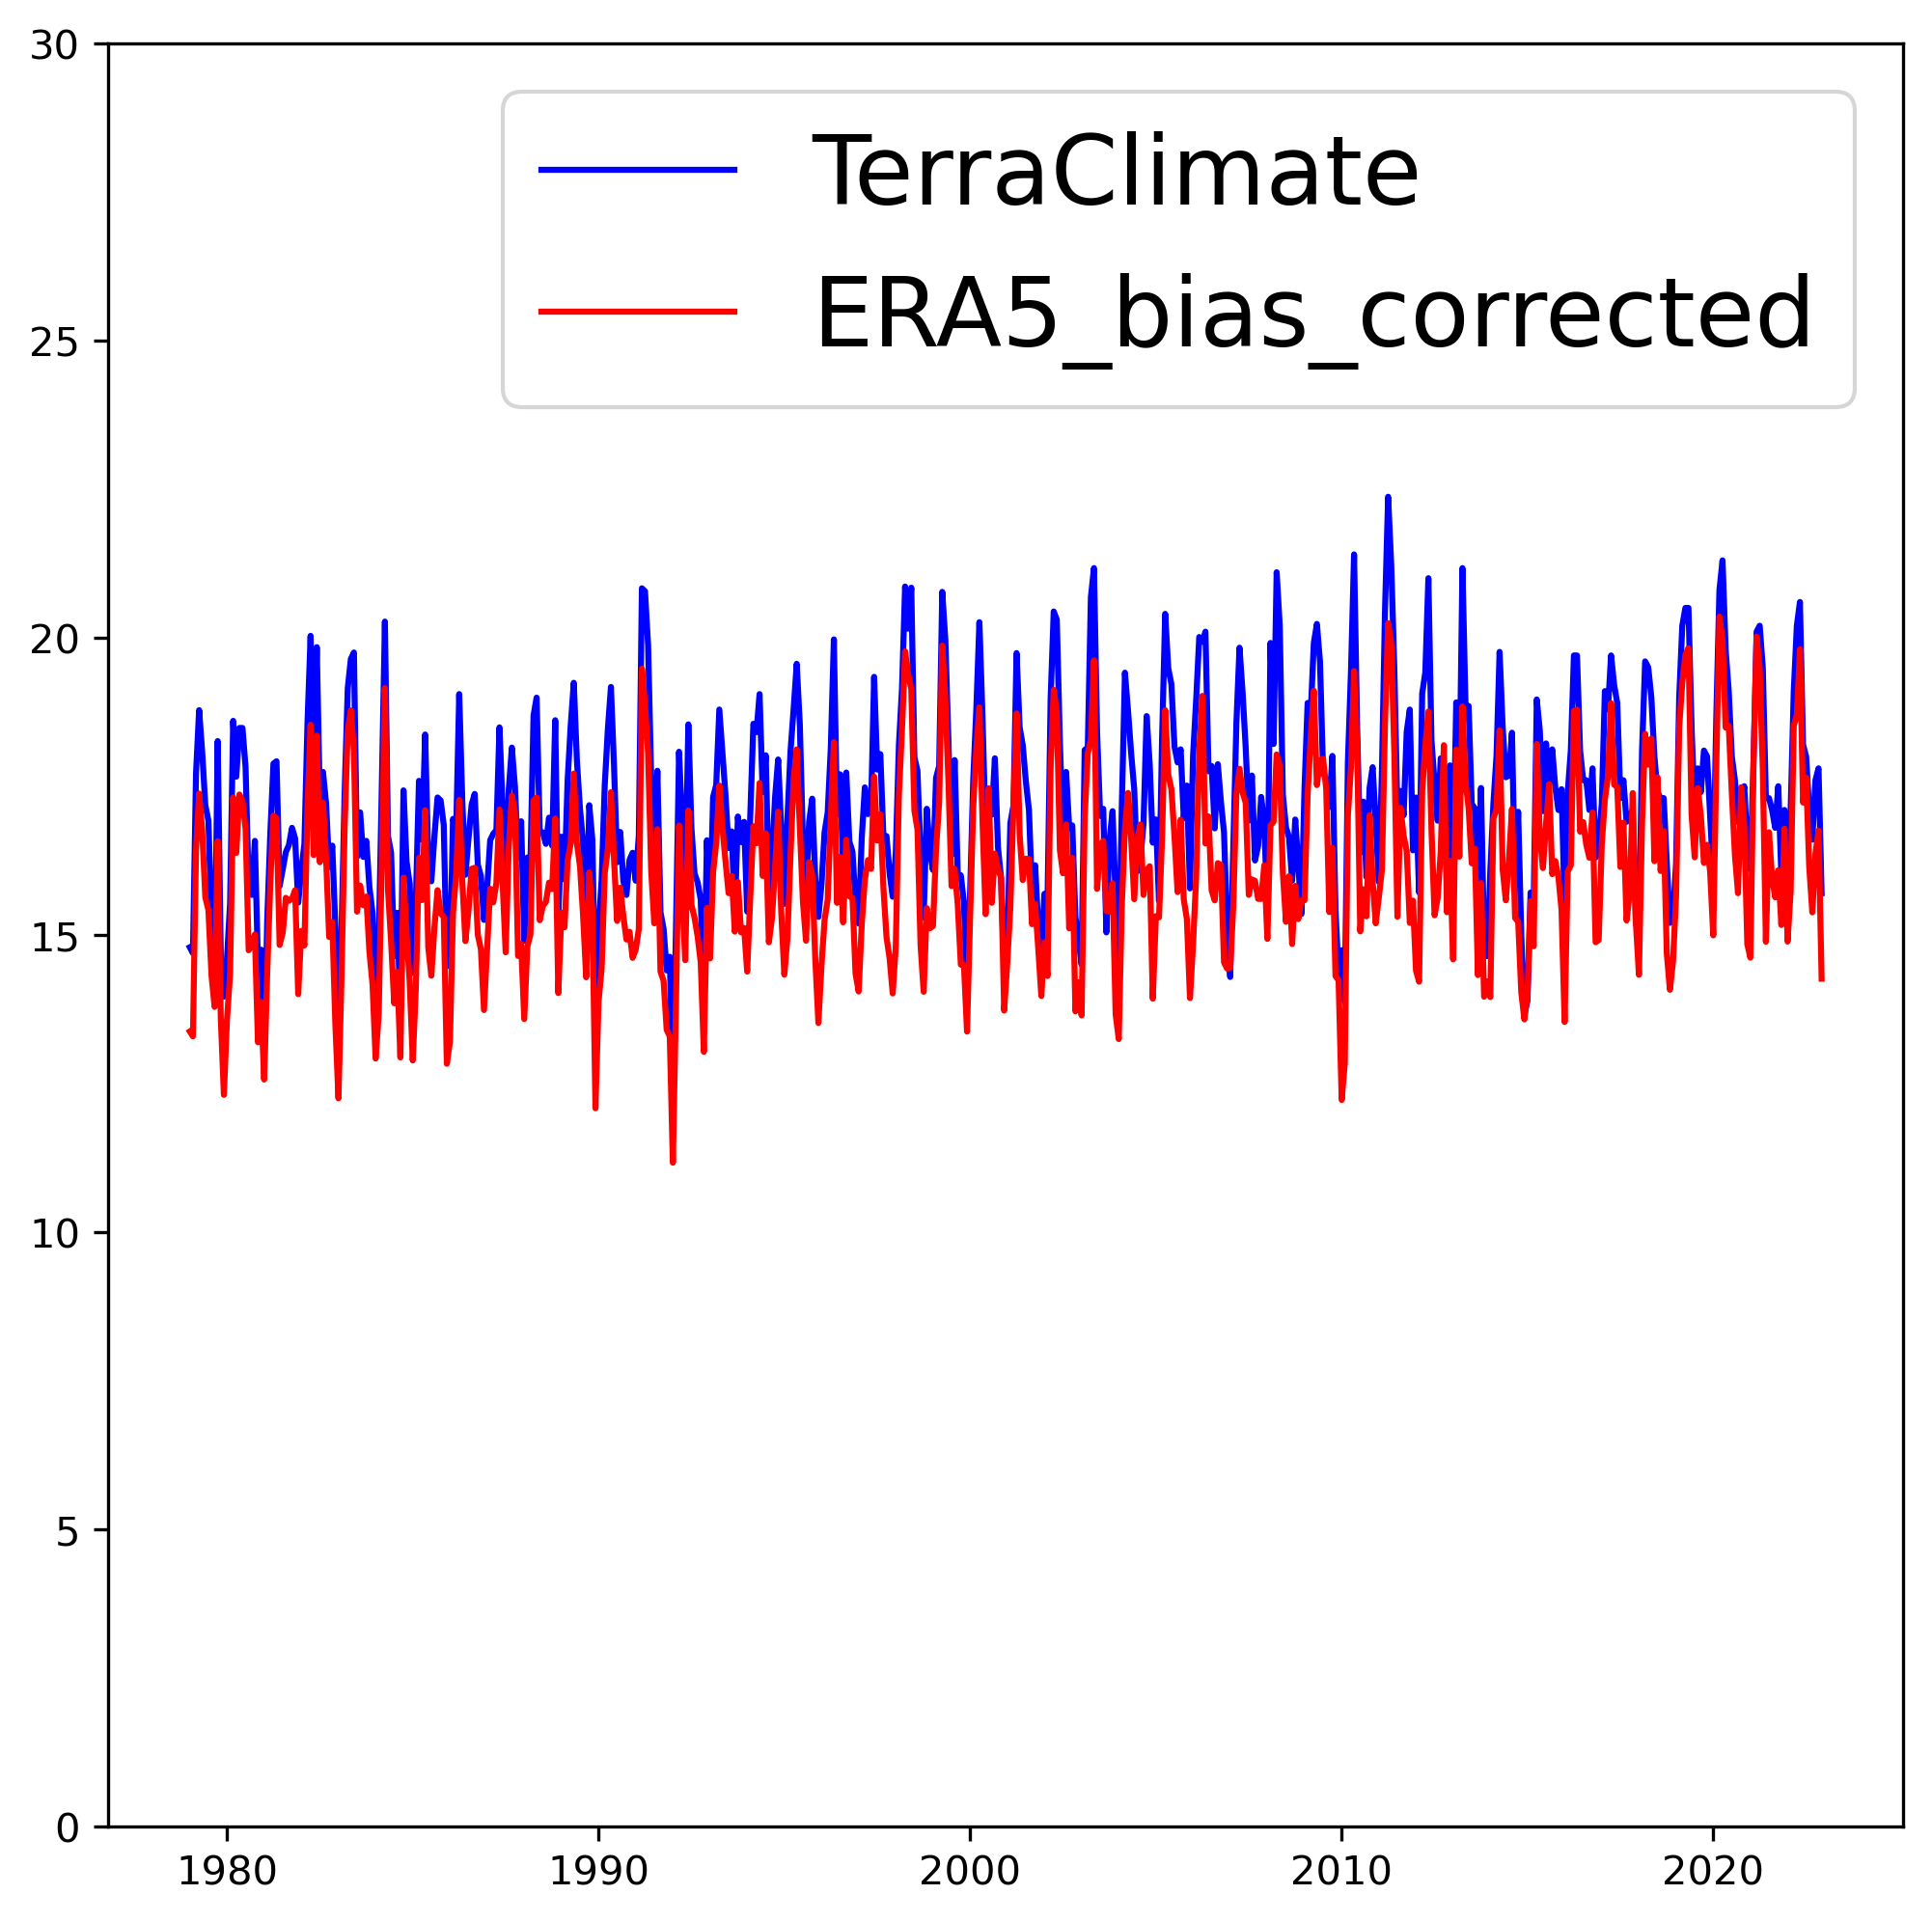

In [17]:
# Comparison Tmax 
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_tmax_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_tmax_era[0:plot_len]-273.16, 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 24)
plt.ylim([0, 30])

(-10.0, 20.0)

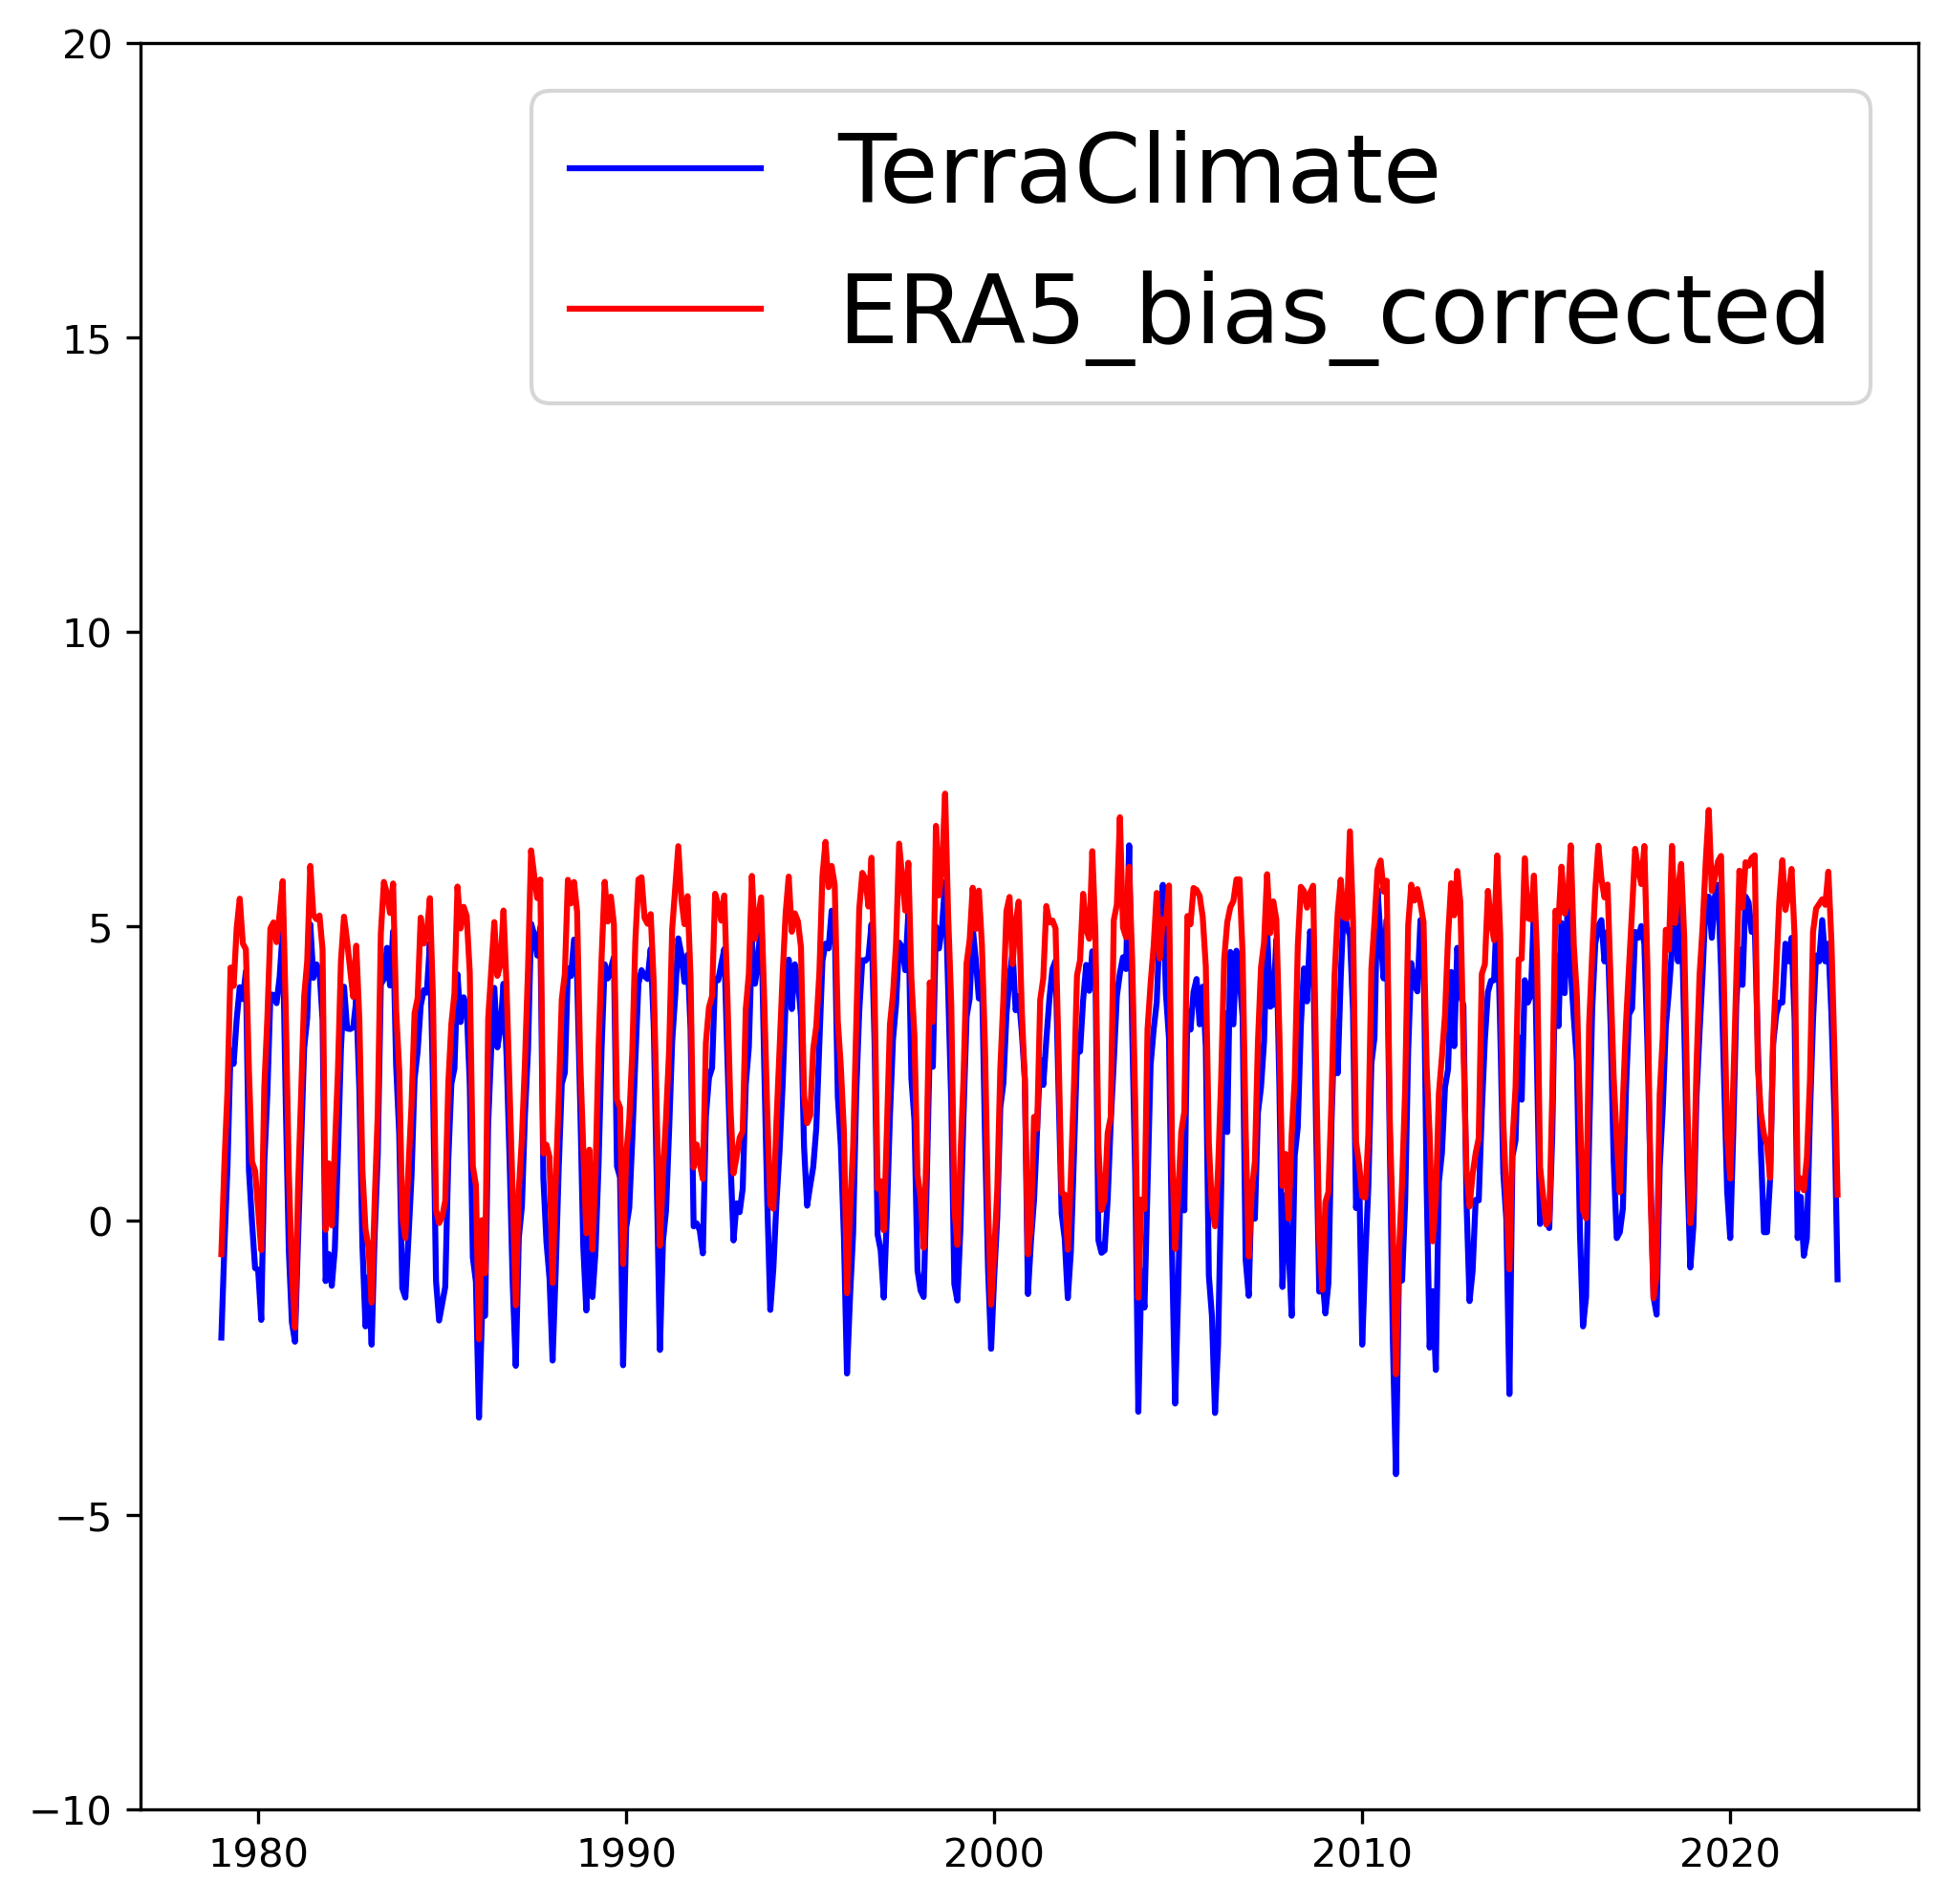

In [19]:
# Comparison Tmin 
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_tmin_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_tmin_era[0:plot_len]-273.16, 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 24)
plt.ylim([-10, 20])

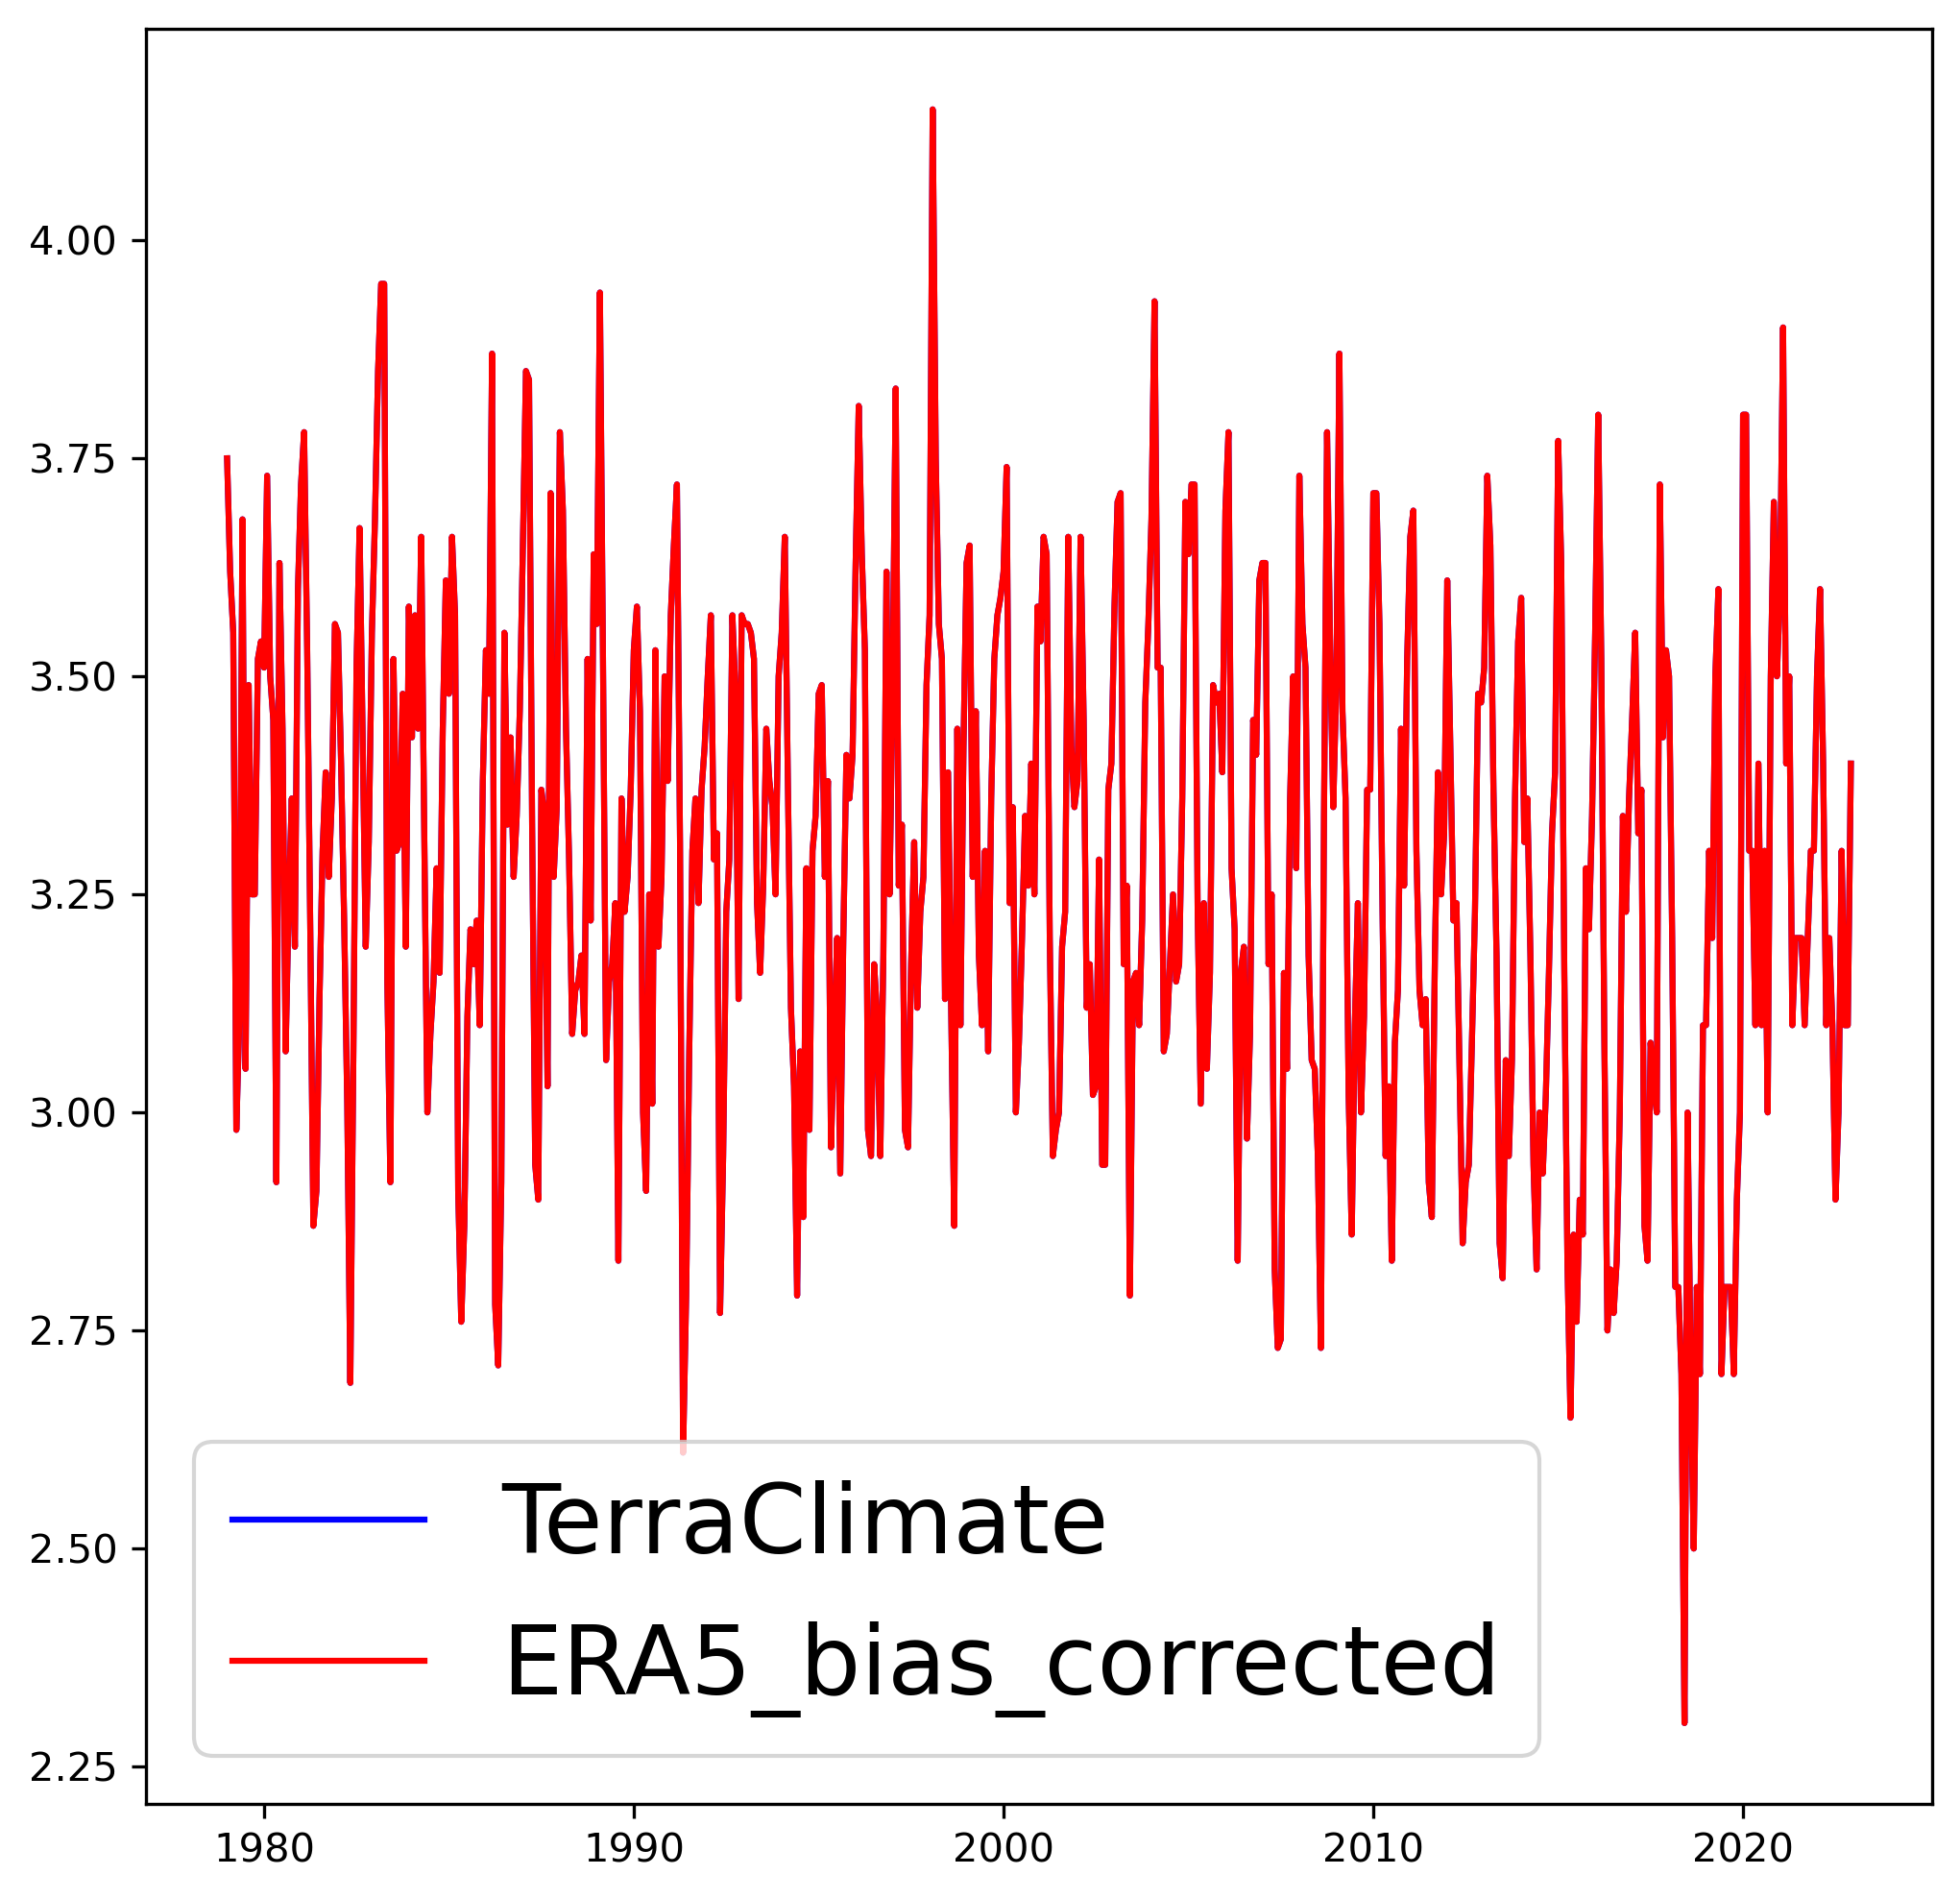

In [20]:
# Comparison Wind
yr_axis = np.arange(1979, 2023, 1.0/12.0)
plot_len = len(yr_axis)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_wind_terra[0:plot_len], 'b-')
plt.plot(yr_axis, sr_wmean_era[0:plot_len], 'r-')
plt.legend(['TerraClimate', 'ERA5_bias_corrected'], fontsize = 24)
# plt.ylim([2, 5])

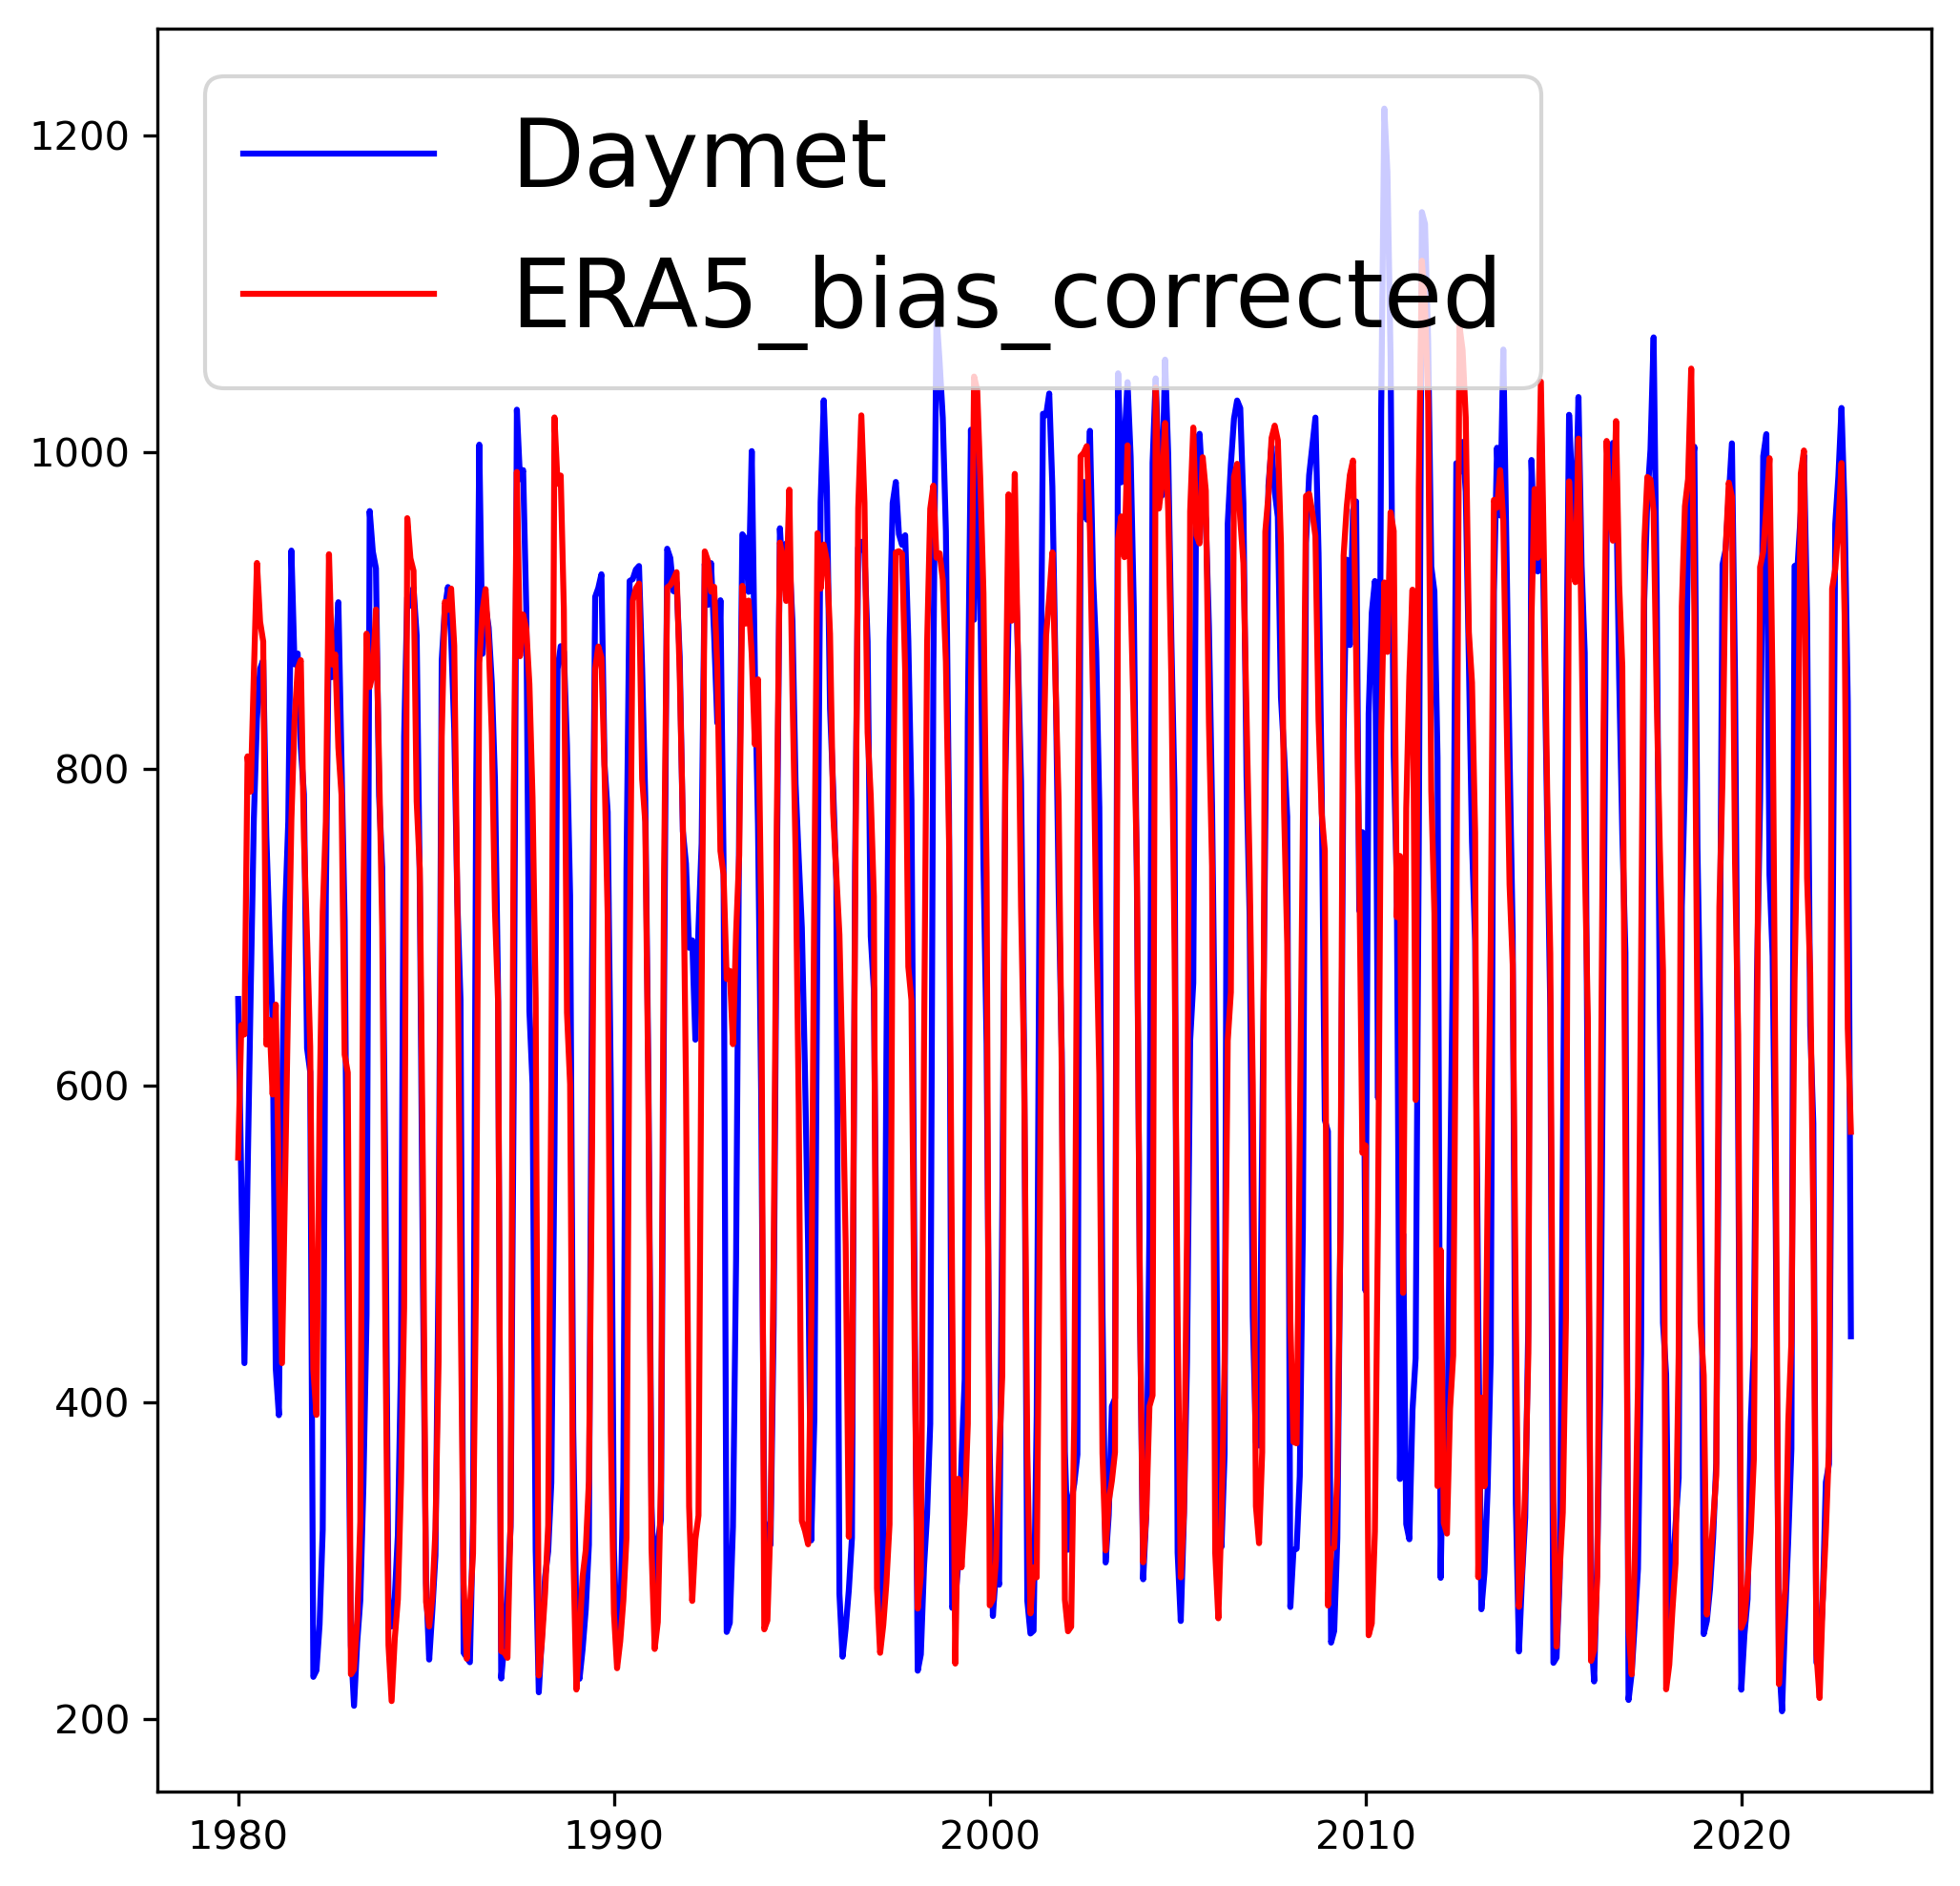

In [32]:
# Comparison EA (Actual vapor pressure, Pa)
yr_axis = np.arange(1980, 2023, 1.0/12.0)
plot_len = len(yr_axis)
sr_ea_daymet_mo = np.zeros((len(yr_axis)))
for i in np.arange(1980,2023):
    for j in np.arange(1,13):
        jday_beg_pt = 365*(i-1980)+jday_beg[j-1]
        jday_end_pt = 365*(i-1980)+jday_end[j-1]
        sr_ea_daymet_mo[(i-1980)*12+j-1] = np.nanmean(sr_ea_daymet[jday_beg_pt:jday_end_pt])
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_ea_daymet_mo[0:plot_len], 'b-')
plt.plot(yr_axis, sr_ea_era[0:plot_len], 'r-')
plt.legend(['Daymet', 'ERA5_bias_corrected'], fontsize = 24)


### Other bias correction if needed?